In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from collections import OrderedDict, Counter
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.2, style='white')

This notebook is used for feature engineering and model selection on a subset of data.

## Preparing dataset

In [2]:
train_order_product = pd.read_csv('../data/subset_order_products.csv')
prior_order_product = pd.read_csv('../data/subset_prior_order_products.csv')

In [3]:
order_info = pd.read_csv('../raw_data/orders.csv')
prior_order_details = pd.merge(prior_order_product, order_info.drop(columns='eval_set'), 
                               on='order_id', how='left')

** Format dataset:   
Each record is a product that the user has ordered the past. The target is whether the user will order the product in the current order (1 for reorder 0 for no order in the subset from the order_products__train.csv)**

In [4]:
prior_reorder_summary = prior_order_details.groupby(['user_id','product_id'], as_index=False)['reordered'].sum()
prior_reorder_summary.rename({'reordered':'user_product_reordered_past'}, axis=1, inplace=True)

In [5]:
prior_reorder_summary.head(3)

,user_id,product_id,user_product_reordered_past
0,2,23,0
1,2,79,0
2,2,1559,5


In [6]:
prior_reorder_summary.shape

(755172, 3)

In [7]:
train_user_id = order_info[order_info['order_id'].isin(train_order_product['order_id'])]['user_id']
prior_valid_user = prior_reorder_summary[prior_reorder_summary['user_id'].isin(train_user_id)]
order_details = pd.merge(train_order_product, order_info.drop(columns='eval_set'), 
                         on='order_id', how='left')

In [8]:
df = pd.merge(prior_valid_user, 
                order_details[['user_id', 'product_id', 'reordered']], 
                on=['user_id', 'product_id'], how='left')

In [9]:
df['reordered'].fillna(0,inplace=True)

In [10]:
df.head()

,user_id,product_id,user_product_reordered_past,reordered
0,2,23,0,0.0
1,2,79,0,0.0
2,2,1559,5,0.0
3,2,2002,3,0.0
4,2,2573,1,0.0


In [11]:
# define function for model evaluation
def cv_model(estimator, df, k=5, scale=False, v=False):
    '''Perform k-fold cross validation on a given model.

    Arguments:
    estimator: the model to be evaludated
    df: dataset including user_id, product_id and whether reordered in current order and other features
    k: fold of cross validation. Default is 5
    scale: whether to scale the feature using StandardScaler from sklearn.preprocessing. Default is False.
    v: whether to print the result in verbose. 
       If False, only mean F1, mean probability adjusted F1, AUC of the validation score and F1 of the training set will be provided.
       Otherwise, in addition to above mentioned, mean accuracy, recall and precision will also be reported.
       It will also plot ROC curve, precision-recall curve and F1 score against probability threshold if True.
    Return:
    The model evaluated, the feature names and the mean probability adjusted f1 score from validation.
    '''
    acc_list=[]
    rec_list=[]
    prec_list=[]
    f1_list=[]
    auc_list=[]
    f1_train=[]  #check train score if see if the model overfits
    i=0
    highest_f1=[]
    if v:  #plot the metrics and report accuracy, recall, precision in additional to f1 and AUC
        fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    kf = KFold(n_splits=k, shuffle=True)
    for user_train_ind, user_val_ind in kf.split(df.user_id.unique()):
    #print(user_train.shape, user_val.shape)
        user_train=df.user_id.unique()[user_train_ind]
        user_val=df.user_id.unique()[user_val_ind]
        df1 = df[df.user_id.isin(user_train)]
        y_train = df1['reordered']
        X_train = df1.drop(columns=['reordered', 'user_id', 'product_id'])
        feature_names=X_train.columns
        df2 = df[df.user_id.isin(user_val)]
        y_val = df2['reordered']
        X_val = df2.drop(columns=['reordered', 'user_id', 'product_id'])    
        #print(user_train.shape, user_val.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)
        if scale == True:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
        model = estimator
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_train = model.predict(X_train)
    
        acc_list.append(accuracy_score(y_val, y_pred))
        rec_list.append(recall_score(y_val, y_pred))
        prec_list.append(precision_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred))
        f1_train.append(f1_score(y_train, y_pred_train))
        
        y_pred_prob = model.predict_proba(X_val)[:,1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob, pos_label=1)
        auc_list.append(auc(fpr, tpr))
        rec, prec, thres = precision_recall_curve(y_val, y_pred_prob, pos_label=1)
        f1s = []
        for r, p, t in zip(rec, prec, thres):
            if r and p:
                f1s.append((2*r*p/(r+p), t, r, p))
        highest_f1.append(sorted(f1s, reverse=True)[0][0])
        if v:
            i += 1
            ax[0].plot(fpr, tpr, label='ROC Fold %d' % i)
            ax[1].plot(rec, prec, label ='Fold %d' %i)
            print('Fold %d highest F1: %.3f at threshold p= %.3f. Recall is %.3f, precision is %.3f' 
                  % (i, *sorted(f1s, reverse=True)[0]))
            ax[2].plot(list(zip(*f1s))[1], list(zip(*f1s))[0], label='Fold %d' %i)
    if v:        
        plt.legend()
        ax[0].set_xlabel('FPR')
        ax[0].set_ylabel('TPR')
        ax[0].set_title('ROC Curve')
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title('Precision-Recall Curve')
        ax[2].set_xlabel('P threshold')
        ax[2].set_ylabel('F1 score')
        ax[2].set_title('F1 Score vs. Positive Class Decision Probability Threshold')

        mean_acc = np.mean(acc_list)
        std_acc = np.std(acc_list)
        mean_rec = np.mean(rec_list)
        std_rec = np.std(rec_list)
        mean_prec = np.mean(prec_list)
        std_prec = np.std(prec_list) 
        print('mean accuracy: %.3f, std accuracy: %.3f' % (mean_acc, std_acc))
        print('mean recall: %.3f, std recall: %.3f' % (mean_rec, std_rec))  
        print('mean precision: %.3f, std accuracy: %.3f' % (mean_prec, std_prec))
    
    mean_f1 = np.mean(f1_list)
    std_f1 = np.std(f1_list)
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)
    mean_f1_train = np.mean(f1_train)
    std_f1_train = np.std(f1_train)
    mean_highest_f1 = np.mean(highest_f1)
    std_highest_f1 = np.std(highest_f1)
    print('mean f1 with probability adjustment: %.3f, std with probability adjustment: %.3f' % (mean_highest_f1, std_highest_f1))
    print('mean F1: %.3f, std AUC: %.3f' % (mean_f1, std_f1))
    print('mean AUC: %.3f, std AUC: %.3f' % (mean_auc, std_auc))
    print('mean train F1: %.3f, std train F1: %.3f' % (mean_f1_train, std_f1_train))
    return model, feature_names, mean_highest_f1

**Set up baseline using Logistic Regression**

Fold 1 highest F1: 0.319 at threshold p= 0.111. Recall is 0.255, precision is 0.426
Fold 2 highest F1: 0.310 at threshold p= 0.098. Recall is 0.220, precision is 0.525
Fold 3 highest F1: 0.308 at threshold p= 0.111. Recall is 0.250, precision is 0.402
Fold 4 highest F1: 0.316 at threshold p= 0.111. Recall is 0.255, precision is 0.416
Fold 5 highest F1: 0.322 at threshold p= 0.097. Recall is 0.230, precision is 0.538
mean accuracy: 0.901, std accuracy: 0.002
mean recall: 0.048, std recall: 0.003
mean precision: 0.484, std accuracy: 0.019
mean f1 with probability adjustment: 0.315, std with probability adjustment: 0.005
mean F1: 0.088, std AUC: 0.005
mean AUC: 0.711, std AUC: 0.003
mean train F1: 0.088, std train F1: 0.001


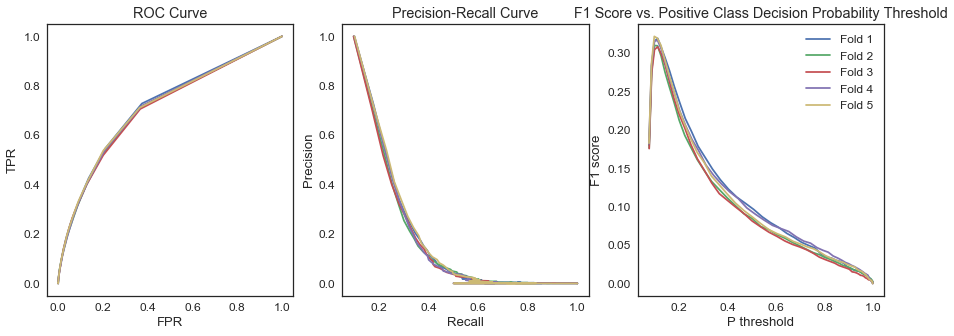

In [12]:
cv_model(LogisticRegression(), df=df, scale=True, v=True);

## Feature Engineering
### User Features
** 1. user_total_order: total order number under the user_id**   
** 2. user_total_product: number of products the user ordered**  
** 3. user_cart_size: average number of products per order for each user**   
** 4. user_likely_dow: how likely the customer shops at weekend vs during the week(convert weekend to 1, weekdays 1, and take average)**  
** 5. user_days_since_last_order_mean: the mean of days between orders**   
** 6. user_total_uniq_product - number of unique products the user ordered **    
** 7. percentage of total product that purchased only once - total_uniq_over_total_product **  
** 8. user_uniq_prod_over_total_prod: unique product proportion among all product. Expect the number to be small if the custerom repeatedly order only a few different products.**


In [13]:
# Add feature: how likely the customer shops at weekend vs during the week
# (convert weekend to 1(0,1), weekdays 0(2-6), and take average) - user_likely_dow
# user_total_order, user_cart_size, user_total_product,user_days_since_last_order_mean, user_days_since_last_order_std
prior_order_details['dow_binary'] = (prior_order_details['order_dow'] < 2 ).astype(int)
user_feature = (prior_order_details.groupby(['user_id', 'order_id'], as_index=False)
            .agg(OrderedDict([('product_id', 'count'), ('days_since_prior_order', 'first'), 
                              ('dow_binary', 'first')])))
user_feature.rename(columns={'product_id': 'total_product'}, inplace=True)
user_feature = (user_feature.groupby(['user_id'], as_index=False)
            .agg(OrderedDict([('order_id','count'), ('total_product', ['mean', 'sum']), ('days_since_prior_order', ['mean', 'std']), 
                             ('dow_binary', 'mean')])))
user_feature_colname = ['user_id', 'user_total_order', 'user_cart_size', 'user_total_product','user_days_since_last_order_mean', 
                        'user_days_since_last_order_std', 'user_likely_dow']
user_feature.columns = user_feature_colname

In [14]:
# Add number of product that the user ordered only once before - user_total_uniq_product
# and total_uniq_over_total_product
user_uniq_product = prior_order_details.groupby('user_id')['product_id'].nunique()
user_feature = pd.merge(user_feature, user_uniq_product.to_frame(), left_on ='user_id', 
                        right_index=True, how='left')
user_feature.rename(columns={'product_id': 'user_total_uniq_product'}, inplace=True)
user_feature['user_uniq_prod_over_total_prod'] = \
user_feature['user_total_uniq_product']/user_feature['user_total_product']
del user_uniq_product

In [15]:
user_feature.head(5)

,user_id,user_total_order,user_cart_size,user_total_product,user_days_since_last_order_mean,user_days_since_last_order_std,user_likely_dow,user_total_uniq_product,user_uniq_prod_over_total_prod
0,2,14,13.928571,195,15.230769,9.867065,0.357143,102,0.523077
1,46,19,8.263158,157,17.722222,9.138191,0.947368,62,0.394904
2,52,27,6.259259,169,9.076923,5.121899,0.555556,51,0.301775
3,77,12,16.916667,203,13.454545,9.223488,0.666667,128,0.630542
4,117,11,10.909091,120,21.000000,10.811516,0.272727,68,0.566667


In [16]:
df = pd.merge(df, user_feature, on='user_id', how='left')

**Evaluate with Logistic Regression Model**

In [17]:
f1s=[]
for c in [1, 10, 100, 10000]:
    print('C=%f' % c)
    model, feature_names, f1 = cv_model(LogisticRegression(penalty='l1', C=c), 
                                        df=df, k=5, scale=True, v=False)
    f1s.append((f1, c, model, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=1.000000
mean f1 with probability adjustment: 0.368, std with probability adjustment: 0.005
mean F1: 0.119, std AUC: 0.006
mean AUC: 0.760, std AUC: 0.003
mean train F1: 0.119, std train F1: 0.003
C=10.000000
mean f1 with probability adjustment: 0.369, std with probability adjustment: 0.009
mean F1: 0.118, std AUC: 0.012
mean AUC: 0.760, std AUC: 0.006
mean train F1: 0.119, std train F1: 0.003
C=100.000000
mean f1 with probability adjustment: 0.369, std with probability adjustment: 0.004
mean F1: 0.119, std AUC: 0.003
mean AUC: 0.760, std AUC: 0.005
mean train F1: 0.119, std train F1: 0.002
C=10000.000000
mean f1 with probability adjustment: 0.369, std with probability adjustment: 0.004
mean F1: 0.118, std AUC: 0.004
mean AUC: 0.760, std AUC: 0.005
mean train F1: 0.119, std train F1: 0.002
Higest f1 score: (0.3688693153892843, 10)


** Adding user features to the model improve the f1 score. Add additional features to improve the model.**  

### Product Features

** 1. product_total_orders - total counts of the product that was ordered in the prior order data **  
** 2. product_avg_add_to_cart_order - average add-to-cart order of the product **  
** 3. product_percent_order_containing_product - what's the proportion of total orders that contain the product**


In [18]:
# Add product specific features:
prod_feature_names = ['product_total_orders', 'product_avg_add_to_cart_order']
prod_feature = prior_order_details.groupby('product_id', as_index=False).agg(OrderedDict([('order_id','count'), 
                                                                    ('add_to_cart_order', 'mean')]))
prod_feature.columns = ['product_id'] + prod_feature_names
prod_feature['product_percent_order_containing_product'] = prod_feature['product_total_orders']/prior_order_details['order_id'].nunique()

#remember to save prod_feature for preparing test
df = pd.merge(df, prod_feature, on='product_id', how='left')

In [19]:
f1s=[]
for c in [1, 10, 100, 10000]:
    print('C=%f' % c)
    model, feature_names, f1 = cv_model(LogisticRegression(penalty='l1', C=c), 
                                        df=df, k=5, scale=True, v=False)
    f1s.append((f1, c, model, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=1.000000
mean f1 with probability adjustment: 0.372, std with probability adjustment: 0.008
mean F1: 0.131, std AUC: 0.015
mean AUC: 0.765, std AUC: 0.005
mean train F1: 0.131, std train F1: 0.003
C=10.000000
mean f1 with probability adjustment: 0.372, std with probability adjustment: 0.007
mean F1: 0.131, std AUC: 0.007
mean AUC: 0.765, std AUC: 0.005
mean train F1: 0.132, std train F1: 0.002
C=100.000000
mean f1 with probability adjustment: 0.371, std with probability adjustment: 0.011
mean F1: 0.131, std AUC: 0.011
mean AUC: 0.765, std AUC: 0.006
mean train F1: 0.131, std train F1: 0.004
C=10000.000000
mean f1 with probability adjustment: 0.372, std with probability adjustment: 0.008
mean F1: 0.131, std AUC: 0.012
mean AUC: 0.765, std AUC: 0.003
mean train F1: 0.132, std train F1: 0.002
Higest f1 score: (0.3719386713112476, 10)


** Adding product features to the model improve the f1 score. Add additional features to improve the model.**  
### Add user-product feature.
** 1. user_product_ave_add_to_cart_order - Average of add to cart order among the orders from each user, not scaled**  
** 2. user_product_ave_add_to_cart_order_scale - Average of add to cart order over scaled within each user (the earlier add-to-cart products are close to 0 and the later on add-to-cart products are close to 1) **  
** 3. user_product_ave_days_since_prior_order - Average days since the prior order each time the user orders the product **  
** 4. user_product_ordered_last_n_order - How long ago did the user last time purchase the product (measure by order) **  
** 5. user_product_days_since_last_product_order - How long ago did the user last time purchase the product (measure by days) **   
** 6. user_product_percent_order_containing_product - proportion of the users orders that contains the product **  
** 7. user_product_ave_day_per_product_order - Average days betweeen the customer order the product **   


In [20]:
# Add user-product feature
# user-product_ave_add_to_cart_order
# user_product_ave_days_since_prior_order
# user_product_ave_add_to_cart_order_scale(average of add to cart over scaled within each user)

prior_order_details['user_product_add_to_cart_order_scale']=(prior_order_details.groupby('order_id')['add_to_cart_order']
                                                           .transform(lambda x: x/max(x)))
user_product_feature = (prior_order_details.groupby(['user_id', 'product_id'], as_index=False)
                   .agg(OrderedDict([('add_to_cart_order', 'mean'), ('user_product_add_to_cart_order_scale', 'mean'),('days_since_prior_order', 'mean'),
                                    ('order_number', 'max')])))
user_product_feature.rename(columns={'add_to_cart_order': 'user_product_ave_add_to_cart_order', 
                                 'user_product_add_to_cart_order_scale':'user_product_ave_add_to_cart_order_scale',
                                'days_since_prior_order':'user_product_ave_days_since_prior_order',
                                'order_number':'user_product_most_recent_order'}, inplace=True)

In [21]:
user_product_feature = pd.merge(user_product_feature, user_feature[['user_id', 'user_total_order']], 
            on='user_id', how='left')
user_product_feature['user_product_ordered_last_n_order'] = (user_product_feature['user_total_order']
                                            - user_product_feature['user_product_most_recent_order'])
user_product_feature.drop(columns='user_total_order', inplace=True)

In [22]:
df_temp=(prior_order_details.groupby(['user_id', 'order_number'], as_index=False)
.agg(OrderedDict([('order_id', 'first'), ('days_since_prior_order', 'first')]))
.sort_values(['user_id', 'order_number'], ascending=[True, False]))
df_temp['cumulative_days_since_nth_order'] = (df_temp.groupby('user_id', as_index=False)['days_since_prior_order']
                                            .cumsum())

In [23]:
df_temp.head(3)

,user_id,order_number,order_id,days_since_prior_order,cumulative_days_since_nth_order
13,2,14,839880,13.0,13.0
12,2,13,3268552,30.0,43.0
11,2,12,3186735,28.0,71.0


In [24]:
a = df_temp['cumulative_days_since_nth_order'].fillna(method='ffill').copy()
a[df_temp['cumulative_days_since_nth_order'].isnull()] +=7
df_temp['cumulative_days_since_nth_order']=a.copy()
del a

In [25]:
user_product_feature = pd.merge(user_product_feature, df_temp.drop(columns=['order_id', 'days_since_prior_order']), 
                    left_on=['user_id', 'user_product_most_recent_order'], right_on = ['user_id', 'order_number'],
                    how='left')

In [26]:
user_product_feature.rename(columns={'cumulative_days_since_nth_order'
                                     :'user_product_days_before_last_product_order'}, inplace=True)

In [27]:
# user_product_ave_days_since_prior_order have NAs. 
# Those are the product the customers ordered only once (in the very first order. 
# Fill NA with user_product_cumulative_days_since_nth_order for the produce (maximum period that the user didn't order the product in this data set.
user_product_feature['user_product_ave_days_since_prior_order'].fillna(user_product_feature['user_product_days_before_last_product_order'], inplace=True)


In [28]:
df = pd.merge(df, user_product_feature.drop(columns='order_number'), 
on=['user_id', 'product_id'], how='left')
# * user_product_percent_order_containing_product 
df['user_product_percent_order_containing_product'] = ((df['user_product_reordered_past'] + 1)
                                                        / df['user_total_order'])

In [29]:
# * on average how many days between the user ordered the product - user_product_ave_day_per_product_order

days_since_first_order = (prior_order_details.groupby(['user_id','order_id'], as_index=False)
                        .agg(OrderedDict([('days_since_prior_order', 'first')]))
.groupby('user_id', as_index=False)['days_since_prior_order'].sum())
days_since_first_order.rename(columns={'days_since_prior_order':'days_since_first_order'}, inplace=True)

In [30]:
df = pd.merge(df, days_since_first_order, on='user_id', how='left')
df['user_product_ave_day_per_product_order'] = df['days_since_first_order']/(df['user_product_reordered_past']+1)
df.drop(columns='days_since_first_order', inplace=True)
del days_since_first_order

### Current order information
** 1. current_order_days_since_last_product_purchase - 'days_since_prior_order' field in the training data**  
** 2. current_order_since_last_product_purchase_vs_average_purchase_gap - ratio of days since last puchase against aveage days between each purchase **  
** 3. current_order_gap_deviation - deviation of days since prior order from the mean order gap **  
** 4. current_same_day_order - whether the customer has already order the product that day (changed to current_same_day_order_in the final model **

In [31]:
current_order_specific = order_details.groupby('user_id', as_index=False).agg(OrderedDict(
       [('days_since_prior_order', 'first'), ('order_hour_of_day', 'first')]))
df = pd.merge(df, current_order_specific, on='user_id', how='left')
df.rename(columns={'days_since_prior_order':'current_days_since_prior_order'},inplace=True)

In [32]:
def process_current_order(row):
    # current_order_since_last_product_purchase_vs_average_purchase_gap
    days_since_last_purchase = row['user_product_days_before_last_product_order'] \
    + row['current_days_since_prior_order']
    # take care of 0
    if row['user_product_ave_day_per_product_order'] == 0:
        row['user_product_ave_day_per_product_order']+=0.5
    if days_since_last_purchase == 0:
        days_since_last_purchase+=0.5
    purchase_days_ratio = days_since_last_purchase\
    /row['user_product_ave_day_per_product_order']
    #deviation on the gaps from current compared to the average of the user
    if row['user_days_since_last_order_std'] == 0:
        gaps_deviation = None
    else:
        gaps_deviation = (row['current_days_since_prior_order'] - 
                          row['user_days_since_last_order_mean'])/row['user_days_since_last_order_std']
    # whether the user has placed an order of the same product that day   
    if row['current_days_since_prior_order'] == 0 and \
    row['user_total_order'] == row['user_product_most_recent_order']:
        same_day = 1
    else:
        same_day = 0
    return days_since_last_purchase, purchase_days_ratio, gaps_deviation, same_day
    

In [33]:
(df['current_order_days_since_last_product_purchase'], 
    df['current_order_since_last_product_purchase_vs_average_purchase_gap'],
    df['current_order_gap_deviation'],
    df['current_same_day_order']) = zip(*df.apply(process_current_order, axis=1))

In [34]:
df['current_order_gap_deviation'].fillna(99999,inplace=True)

In [35]:
df.drop(columns=['user_product_most_recent_order', 
                 'user_product_days_before_last_product_order',
                'user_days_since_last_order_std'], inplace=True)

In [36]:
df.head(3)

,user_id,product_id,user_product_reordered_past,reordered,user_total_order,user_cart_size,user_total_product,user_days_since_last_order_mean,user_likely_dow,user_total_uniq_product,...,user_product_ave_days_since_prior_order,user_product_ordered_last_n_order,user_product_percent_order_containing_product,user_product_ave_day_per_product_order,current_days_since_prior_order,order_hour_of_day,current_order_days_since_last_product_purchase,current_order_since_last_product_purchase_vs_average_purchase_gap,current_order_gap_deviation,current_same_day_order
0,2,23,0,0.0,14,13.928571,195,15.230769,0.357143,102,...,27.0,6,0.071429,198.0,30.0,11,172.0,0.868687,1.496821,0
1,2,79,0,0.0,14,13.928571,195,15.230769,0.357143,102,...,30.0,1,0.071429,198.0,30.0,11,73.0,0.368687,1.496821,0
2,2,1559,5,0.0,14,13.928571,195,15.230769,0.357143,102,...,15.5,0,0.428571,33.0,30.0,11,43.0,1.303030,1.496821,0


**Evaluate by logistic regression:**

In [37]:
f1s=[]
for c in [1, 10, 100, 10000]:
    print('C=%f' % c)
    model, feature_names, f1 = cv_model(LogisticRegression(penalty='l1', C=c), 
                                        df=df, 
                                        k=5, scale=True, v=False)
    f1s.append((f1, c, model, feature_names))
print('Higest f1 score:', sorted(f1s, reverse=True)[0][:2])

C=1.000000
mean f1 with probability adjustment: 0.427, std with probability adjustment: 0.011
mean F1: 0.247, std AUC: 0.013
mean AUC: 0.819, std AUC: 0.003
mean train F1: 0.248, std train F1: 0.006
C=10.000000
mean f1 with probability adjustment: 0.427, std with probability adjustment: 0.004
mean F1: 0.248, std AUC: 0.004
mean AUC: 0.819, std AUC: 0.003
mean train F1: 0.249, std train F1: 0.002
C=100.000000
mean f1 with probability adjustment: 0.427, std with probability adjustment: 0.009
mean F1: 0.248, std AUC: 0.005
mean AUC: 0.819, std AUC: 0.005
mean train F1: 0.248, std train F1: 0.003
C=10000.000000
mean f1 with probability adjustment: 0.428, std with probability adjustment: 0.007
mean F1: 0.248, std AUC: 0.011
mean AUC: 0.819, std AUC: 0.003
mean train F1: 0.248, std train F1: 0.004
Higest f1 score: (0.42819162019451673, 10000)


** As the relation between features and target might be non-linear, try evaluating by random forest:**

In [38]:
f1s=[]
for m in range(30,51,5): #over_fitting when n> 13
    
    print('max_depth=%d, n_estimator=%d' % (m, 500))
    rf, feature_names, f1 = cv_model(RandomForestClassifier(max_depth=m, n_estimators=500, min_samples_leaf=75,
                                                             n_jobs=-1,), df=df,
                                      k=5, scale=False, v=False)
    f1s.append((f1, 500, m, rf, feature_names))
print(sorted(f1s, reverse=True)[:2][:4])

max_depth=30, n_estimator=500
mean f1 with probability adjustment: 0.433, std with probability adjustment: 0.005
mean F1: 0.232, std AUC: 0.003
mean AUC: 0.824, std AUC: 0.004
mean train F1: 0.256, std train F1: 0.003
max_depth=35, n_estimator=500
mean f1 with probability adjustment: 0.432, std with probability adjustment: 0.007
mean F1: 0.230, std AUC: 0.004
mean AUC: 0.824, std AUC: 0.004
mean train F1: 0.255, std train F1: 0.002
max_depth=40, n_estimator=500
mean f1 with probability adjustment: 0.433, std with probability adjustment: 0.004
mean F1: 0.230, std AUC: 0.007
mean AUC: 0.824, std AUC: 0.003
mean train F1: 0.255, std train F1: 0.003
max_depth=45, n_estimator=500
mean f1 with probability adjustment: 0.433, std with probability adjustment: 0.009
mean F1: 0.230, std AUC: 0.010
mean AUC: 0.824, std AUC: 0.004
mean train F1: 0.255, std train F1: 0.004
max_depth=50, n_estimator=500
mean f1 with probability adjustment: 0.433, std with probability adjustment: 0.007
mean F1: 0.231,

In [39]:
def cv_xgb(df, k=5, n_estimators=30000, max_depth=3, objective="binary:logistic", learning_rate=.1, subsample=1, 
           min_child_weight=1, colsample_bytree=.8, v=False):
    rec_list=[]
    prec_list=[]
    f1_list=[]
    auc_list=[]
    f1_train=[]  #check train score if see if the model overfits
    i=0
    highest_f1=[]
    if v:
        fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    kf = KFold(n_splits=k, shuffle=True)
    for user_train_ind, user_val_ind in kf.split(df.user_id.unique()):
    #print(user_train.shape, user_val.shape)
        user_train=df.user_id.unique()[user_train_ind]
        user_val=df.user_id.unique()[user_val_ind]
        df1 = df[df.user_id.isin(user_train)]
        y_train = df1['reordered']
        X_train = df1.drop(columns=['reordered', 'user_id', 'product_id'])
        feature_names=X_train.columns
        df2 = df[df.user_id.isin(user_val)]
        y_val = df2['reordered']
        X_val = df2.drop(columns=['reordered', 'user_id', 'product_id'])    
        #print(user_train.shape, user_val.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape)
        
        gbm =  xgb.XGBClassifier( 
                               n_estimators = n_estimators, #arbitrary large number
                               max_depth = max_depth,
                               objective = objective,
                               learning_rate = learning_rate, 
                               subsample = subsample,
                               min_child_weight = min_child_weight,
                               colsample_bytree = colsample_bytree
                                  )
        eval_set=[(X_train,y_train),(X_val,y_val)]
        fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=50,
                    verbose=False #gives output log as below
                   )
        y_pred = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)
        y_pred_train = gbm.predict(X_train, ntree_limit=gbm.best_ntree_limit)
    
        #acc_list.append(accuracy_score(y_val, y_pred))
        rec_list.append(recall_score(y_val, y_pred))
        prec_list.append(precision_score(y_val, y_pred))
        f1_list.append(f1_score(y_val, y_pred))
        f1_train.append(f1_score(y_train, y_pred_train))
        
        y_pred_prob = gbm.predict_proba(X_val, ntree_limit=gbm.best_ntree_limit)[:,1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_prob, pos_label=1)
        auc_list.append(auc(fpr, tpr))
        if v:
            i += 1
            ax[0].plot(fpr, tpr, label='ROC Fold %d' % i)
        rec, prec, thres = precision_recall_curve(y_val, y_pred_prob, pos_label=1)
        if v:
            ax[1].plot(rec, prec, label ='Fold %d' %i)
        f1s = []
        for r, p, t in zip(rec, prec, thres):
            if r and p:
                f1s.append((2*r*p/(r+p), t, r, p))
        if v:
            print('Fold %d highest F1: %.3f at threshold p= %.3f. Recall is %.3f, precision is %.3f' 
                  % (i, *sorted(f1s, reverse=True)[0]))
        highest_f1.append(sorted(f1s, reverse=True)[0][0])
        if v:
            ax[2].plot(list(zip(*f1s))[1], list(zip(*f1s))[0], label='Fold %d' %i)
    if v:        
        plt.legend()
        ax[0].set_xlabel('FPR')
        ax[0].set_ylabel('TPR')
        ax[0].set_title('ROC Curve')
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title('Precision-Recall Curve')
        ax[2].set_xlabel('P threshold')
        ax[2].set_ylabel('F1 score')
        ax[2].set_title('F1 Score vs. Positive Class Decision Probability Threshold')

    if v:
        #mean_acc = np.mean(acc_list)
        #std_acc = np.std(acc_list)
        mean_rec = np.mean(rec_list)
        std_rec = np.std(rec_list)
        mean_prec = np.mean(prec_list)
        std_prec = np.std(prec_list) 
        #print('mean accuracy: %.3f, std accuracy: %.3f' % (mean_acc, std_acc))
        print('mean recall: %.3f, std recall: %.3f' % (mean_rec, std_rec))  
        print('mean precision: %.3f, std accuracy: %.3f' % (mean_prec, std_prec))
        print('best_n: ', gbm.best_ntree_limit)
    
    mean_f1 = np.mean(f1_list)
    std_f1 = np.std(f1_list)
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)
    mean_f1_train = np.mean(f1_train)
    std_f1_train = np.std(f1_train)
    mean_highest_f1 = np.mean(highest_f1)
    std_highest_f1 = np.std(highest_f1)
    print('mean highest_f1: %.3f, std highest_f1: %.3f' % (mean_highest_f1, std_highest_f1))
    print('mean F1: %.3f, std AUC: %.3f' % (mean_f1, std_f1))
    print('mean AUC: %.3f, std AUC: %.3f' % (mean_auc, std_auc))
    print('mean train F1: %.3f, std train F1: %.3f' % (mean_f1_train, std_f1_train))
    return gbm, feature_names, mean_highest_f1

In [40]:
f1s=[]
for m in np.linspace(0.02, 0.06, 5):
    for n in [4,5,6]:
        print('learning_rate=%f, max_depth=%f' % (m,n))
        gbm,feature_names, f1 = cv_xgb(df=df, 
                                       k=5, n_estimators=30000, max_depth=n, objective="binary:logistic", 
               learning_rate=m, subsample=0.5, colsample_bytree=0.3, v=False)
        f1s.append((f1, n, m, gbm, feature_names))
print(sorted(f1s, reverse=True)[0][:3])

learning_rate=0.020000, max_depth=4.000000
mean highest_f1: 0.435, std highest_f1: 0.005
mean F1: 0.267, std AUC: 0.007
mean AUC: 0.826, std AUC: 0.003
mean train F1: 0.285, std train F1: 0.005
learning_rate=0.020000, max_depth=5.000000
mean highest_f1: 0.433, std highest_f1: 0.009
mean F1: 0.221, std AUC: 0.095
mean AUC: 0.826, std AUC: 0.006
mean train F1: 0.242, std train F1: 0.103
learning_rate=0.020000, max_depth=6.000000
mean highest_f1: 0.435, std highest_f1: 0.008
mean F1: 0.262, std AUC: 0.007
mean AUC: 0.826, std AUC: 0.002
mean train F1: 0.294, std train F1: 0.002
learning_rate=0.030000, max_depth=4.000000
mean highest_f1: 0.435, std highest_f1: 0.008
mean F1: 0.268, std AUC: 0.009
mean AUC: 0.827, std AUC: 0.003
mean train F1: 0.285, std train F1: 0.006
learning_rate=0.030000, max_depth=5.000000
mean highest_f1: 0.435, std highest_f1: 0.007
mean F1: 0.266, std AUC: 0.007
mean AUC: 0.827, std AUC: 0.003
mean train F1: 0.290, std train F1: 0.009
learning_rate=0.030000, max_de

Gradient boosting performs better. Try add some catagorical features about the product and order. Since tree based model will be used, no need to convert them to dummy variables. 
### Binned catagorical feature:
** 1. department**  
** 2. Aisle**  
** 3. Hour of the day**


In [41]:
product_df=pd.read_csv('../raw_data/products.csv')
df=pd.merge(df, product_df, on='product_id', how='left')
df.drop(columns='product_name', inplace=True)

In [42]:
# creat bin by department
print('Binnig department...')
no_order_ratio = df.loc[df['reordered']==0,'department_id'].value_counts().sort_index()/\
df.loc[df['reordered']==0,'department_id'].count()
re_order_ratio = df.loc[df['reordered']==1,'department_id'].value_counts().sort_index()/\
df.loc[df['reordered']==1,'department_id'].count()

dept_freq  = pd.DataFrame(no_order_ratio)
dept_freq.columns=['no_reorder']
dept_freq = pd.merge(dept_freq, re_order_ratio.to_frame(), left_index=True, right_index=True, how='outer')
dept_freq.rename(columns={'department_id':'reordered'}, inplace =True)
dept_freq['diff'] = dept_freq['reordered'] - dept_freq['no_reorder']
dept_freq.sort_values('diff', ascending=False, inplace=True)

dept_freq['dept_bin']=0
dept_freq.loc[(dept_freq['diff']>=0.02), 'dept_bin'] = 2
dept_freq.loc[(dept_freq['diff']<0.02) & (dept_freq['diff']>= 0 ),  'dept_bin'] = 1
dept_freq.loc[(dept_freq['diff']<0) & (dept_freq['diff']>= -0.01 ),  'dept_bin'] = -1
dept_freq.loc[(dept_freq['diff']<-0.01) & (dept_freq['diff']>= -0.02 ),  'dept_bin'] = -2
dept_freq.loc[(dept_freq['diff']<-0.02),  'dept_bin'] = -3
dept_map = dept_freq['dept_bin']
df['product_dept_bin'] = df['department_id'].map(dept_map)
df.drop(columns='department_id', inplace=True)

# create bin by aisle
print('Binnig aisle...')
no_order_ratio = df.loc[df['reordered']==0,'aisle_id'].value_counts().sort_index()/\
df.loc[df['reordered']==0,'aisle_id'].count()
re_order_ratio = df.loc[df['reordered']==1,'aisle_id'].value_counts().sort_index()/\
df.loc[df['reordered']==1,'aisle_id'].count()

aisle_freq  = pd.DataFrame(no_order_ratio)
aisle_freq.columns=['no_reorder']
aisle_freq = pd.merge(aisle_freq, re_order_ratio.to_frame(), left_index=True, right_index=True, how='outer')
aisle_freq.fillna(0, inplace=True)
aisle_freq.rename(columns={'aisle_id':'reordered'}, inplace =True)
aisle_freq['diff'] = aisle_freq['reordered'] - aisle_freq['no_reorder']
aisle_freq['product_aisle_bin'] = 0
aisle_freq.loc[aisle_freq['diff']>=0.001, 'product_aisle_bin'] = 2
aisle_freq.loc[aisle_freq['diff']<=-0.001, 'product_aisle_bin'] = -2
aisle_freq.loc[(aisle_freq['diff']<0.001) & (aisle_freq['diff']>=0), 'product_aisle_bin'] = 1
aisle_freq.loc[(aisle_freq['diff']>-0.001) & (aisle_freq['diff']<0), 'product_aisle_bin'] = -1

aisle_map = aisle_freq['product_aisle_bin']
df['product_aisle_bin'] = df['aisle_id'].map(aisle_map)
df.drop(columns='aisle_id', inplace=True)

# bin hour of day in the current order
print('Binnig hour of day in the current order...')
no_order_ratio = df.loc[df['reordered']==0,'order_hour_of_day'].value_counts().sort_index()/\
df.loc[df['reordered']==0,'order_hour_of_day'].count()
re_order_ratio =df.loc[df['reordered']==1,'order_hour_of_day'].value_counts().sort_index()/\
df.loc[df['reordered']==1,'order_hour_of_day'].count()

product_hod_freq = pd.DataFrame(no_order_ratio)
product_hod_freq.columns=['no_reorder']
product_hod_freq = pd.concat([product_hod_freq, re_order_ratio.to_frame()], axis=1)
product_hod_freq.rename(columns={'order_hour_of_day':'reordered'}, inplace=True)
product_hod_freq['diff'] = product_hod_freq['reordered'] - product_hod_freq['no_reorder']

product_hod_freq['user_current_hod_bin'] = 0
product_hod_freq.loc[(product_hod_freq['diff']>=0), 'user_current_hod_bin']=1
product_hod_freq.loc[(product_hod_freq['diff']<0), 'user_current_hod_bin']=-1

df['current_order_hod'] = (df['order_hour_of_day']
                            .map(product_hod_freq['user_current_hod_bin']))
df.drop(columns='order_hour_of_day', inplace=True)

Binnig department...
Binnig aisle...
Binnig hour of day in the current order...


In [43]:
df.shape

(380445, 28)

In [44]:
f1s=[]
for m in np.linspace(0.01, 0.06, 6):
    for n in [4,5,6]:
        print('learning_rate=%f, max_depth=%f' % (m,n))
        gbm,feature_names, f1 = cv_xgb(df=df, 
                                       k=5, n_estimators=30000, max_depth=n, objective="binary:logistic", 
               learning_rate=m, subsample=0.5, colsample_bytree=0.3, v=False)
        f1s.append((f1, n, m, gbm, feature_names))
print(sorted(f1s, reverse=True)[0][:3])

learning_rate=0.010000, max_depth=4.000000
mean highest_f1: 0.434, std highest_f1: 0.004
mean F1: 0.223, std AUC: 0.093
mean AUC: 0.826, std AUC: 0.005
mean train F1: 0.238, std train F1: 0.100
learning_rate=0.010000, max_depth=5.000000
mean highest_f1: 0.437, std highest_f1: 0.006
mean F1: 0.269, std AUC: 0.007
mean AUC: 0.828, std AUC: 0.002
mean train F1: 0.292, std train F1: 0.006
learning_rate=0.010000, max_depth=6.000000
mean highest_f1: 0.437, std highest_f1: 0.009
mean F1: 0.266, std AUC: 0.009
mean AUC: 0.828, std AUC: 0.003
mean train F1: 0.296, std train F1: 0.003
learning_rate=0.020000, max_depth=4.000000
mean highest_f1: 0.437, std highest_f1: 0.005
mean F1: 0.271, std AUC: 0.013
mean AUC: 0.828, std AUC: 0.003
mean train F1: 0.288, std train F1: 0.007
learning_rate=0.020000, max_depth=5.000000
mean highest_f1: 0.437, std highest_f1: 0.003
mean F1: 0.268, std AUC: 0.005
mean AUC: 0.828, std AUC: 0.002
mean train F1: 0.291, std train F1: 0.009
learning_rate=0.020000, max_de

Check importance gain to see how each feature contributes to the model.

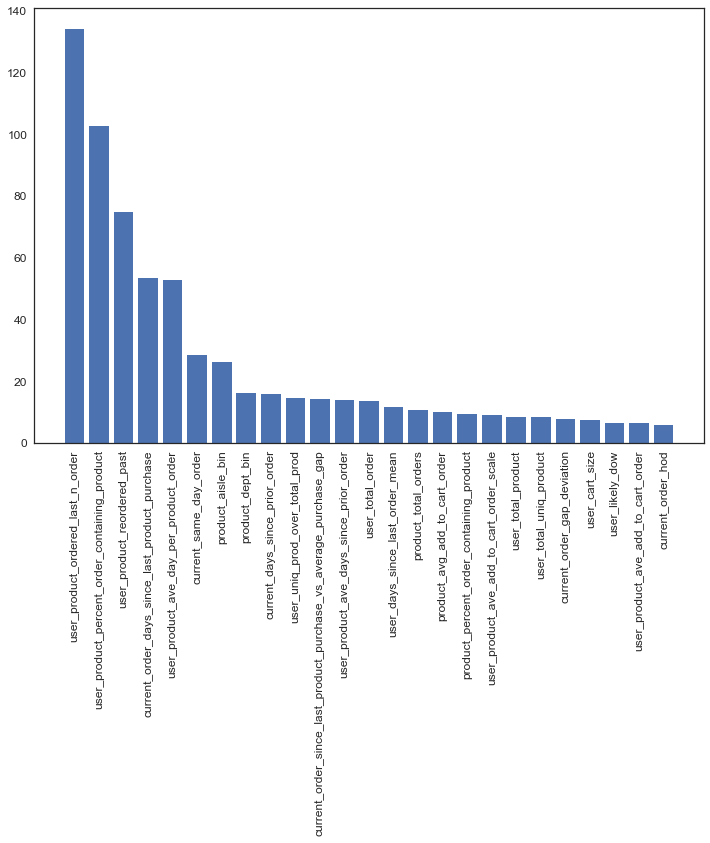

In [45]:
#plot importance gain 
gbm = sorted(f1s, reverse=True)[0][3]
gain = gbm.get_booster().get_score(importance_type='gain')
f_gain, gscore = zip(*sorted(gain.items(), key=lambda x:x[1], reverse=True))
x = range(len(gain))
plt.figure(figsize=(12,8))
plt.bar(x, gscore)
plt.xticks(x,f_gain, rotation=90);

** Remove the three feature with least contribution to see if the model can be improved.**

In [46]:
f1s=[]
for m in np.linspace(0.01, 0.06, 6):
    for n in [4,5,6]:
        print('learning_rate=%f, max_depth=%f' % (m,n))
        gbm,feature_names, f1 = cv_xgb(df=df.drop(columns=['current_order_hod', 'user_likely_dow', 'user_product_ave_add_to_cart_order']), 
                                       k=5, n_estimators=30000, max_depth=n, objective="binary:logistic", 
               learning_rate=m, subsample=0.5, colsample_bytree=0.3, v=False)
        f1s.append((f1, n, m, gbm, feature_names))
print(sorted(f1s, reverse=True)[0][:3])

learning_rate=0.010000, max_depth=4.000000
mean highest_f1: 0.429, std highest_f1: 0.008
mean F1: 0.107, std AUC: 0.125
mean AUC: 0.822, std AUC: 0.005
mean train F1: 0.118, std train F1: 0.138
learning_rate=0.010000, max_depth=5.000000
mean highest_f1: 0.435, std highest_f1: 0.009
mean F1: 0.216, std AUC: 0.104
mean AUC: 0.827, std AUC: 0.005
mean train F1: 0.237, std train F1: 0.115
learning_rate=0.010000, max_depth=6.000000
mean highest_f1: 0.438, std highest_f1: 0.006
mean F1: 0.263, std AUC: 0.007
mean AUC: 0.828, std AUC: 0.003
mean train F1: 0.296, std train F1: 0.003
learning_rate=0.020000, max_depth=4.000000
mean highest_f1: 0.436, std highest_f1: 0.005
mean F1: 0.269, std AUC: 0.008
mean AUC: 0.828, std AUC: 0.003
mean train F1: 0.286, std train F1: 0.004
learning_rate=0.020000, max_depth=5.000000
mean highest_f1: 0.436, std highest_f1: 0.006
mean F1: 0.270, std AUC: 0.004
mean AUC: 0.828, std AUC: 0.003
mean train F1: 0.296, std train F1: 0.006
learning_rate=0.020000, max_de

In [47]:
f1s=[]
for m in np.linspace(0.3, 0.7, 5):
    for n in np.linspace(0.3, 0.7, 5):
        print('subsample=%f, colsample_bytree=%f' % (m,n))
        gbm,feature_names, f1 = cv_xgb(df=df.drop(columns=['current_order_hod', 'user_likely_dow', 'user_product_ave_add_to_cart_order']), 
                                       k=5, n_estimators=30000, max_depth=6, objective="binary:logistic", 
               learning_rate=0.01, subsample=m, colsample_bytree=n, v=False)
        f1s.append((f1, n, m, gbm, feature_names))
print(sorted(f1s, reverse=True)[0][:3])

subsample=0.300000, colsample_bytree=0.300000
mean highest_f1: 0.437, std highest_f1: 0.009
mean F1: 0.230, std AUC: 0.077
mean AUC: 0.827, std AUC: 0.007
mean train F1: 0.255, std train F1: 0.080
subsample=0.300000, colsample_bytree=0.400000
mean highest_f1: 0.437, std highest_f1: 0.008
mean F1: 0.268, std AUC: 0.010
mean AUC: 0.828, std AUC: 0.002
mean train F1: 0.295, std train F1: 0.003
subsample=0.300000, colsample_bytree=0.500000
mean highest_f1: 0.438, std highest_f1: 0.007
mean F1: 0.271, std AUC: 0.011
mean AUC: 0.829, std AUC: 0.004
mean train F1: 0.295, std train F1: 0.004
subsample=0.300000, colsample_bytree=0.600000
mean highest_f1: 0.438, std highest_f1: 0.011
mean F1: 0.271, std AUC: 0.012
mean AUC: 0.829, std AUC: 0.005
mean train F1: 0.298, std train F1: 0.008
subsample=0.300000, colsample_bytree=0.700000
mean highest_f1: 0.439, std highest_f1: 0.014
mean F1: 0.270, std AUC: 0.011
mean AUC: 0.829, std AUC: 0.004
mean train F1: 0.297, std train F1: 0.005
subsample=0.400

Fold 1 highest F1: 0.434 at threshold p= 0.193. Recall is 0.366, precision is 0.533
Fold 2 highest F1: 0.432 at threshold p= 0.225. Recall is 0.389, precision is 0.487
Fold 3 highest F1: 0.448 at threshold p= 0.226. Recall is 0.407, precision is 0.500
Fold 4 highest F1: 0.430 at threshold p= 0.212. Recall is 0.379, precision is 0.497
Fold 5 highest F1: 0.443 at threshold p= 0.201. Recall is 0.386, precision is 0.520
mean recall: 0.173, std recall: 0.008
mean precision: 0.620, std accuracy: 0.013
best_n:  843
mean highest_f1: 0.438, std highest_f1: 0.007
mean F1: 0.270, std AUC: 0.010
mean AUC: 0.829, std AUC: 0.004
mean train F1: 0.299, std train F1: 0.003


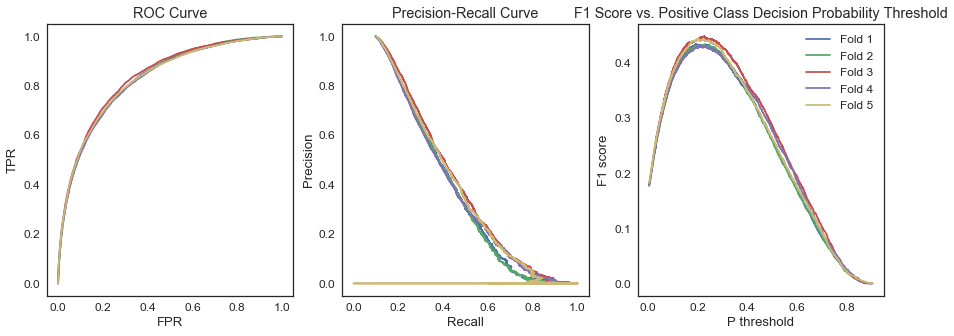

In [48]:
gbm_final,feature_names_final, f1 = cv_xgb(df=df.drop(columns=['current_order_hod', 'user_likely_dow', 'user_product_ave_add_to_cart_order']), 
                               k=5, n_estimators=30000, max_depth=6, objective="binary:logistic", 
       learning_rate=0.01, subsample=0.3, colsample_bytree=0.7, v=True)

#### ** Hyperparameter for the model:**  

n_estimators = 843
max_depth = 6,  
objective = "binary:logistic",  
learning_rate = 0.01,  
subsample = 0.3,    
min_child_weight = 2,  
colsample_bytree = 0.7,   
Prediction Threshold p = 0.2114